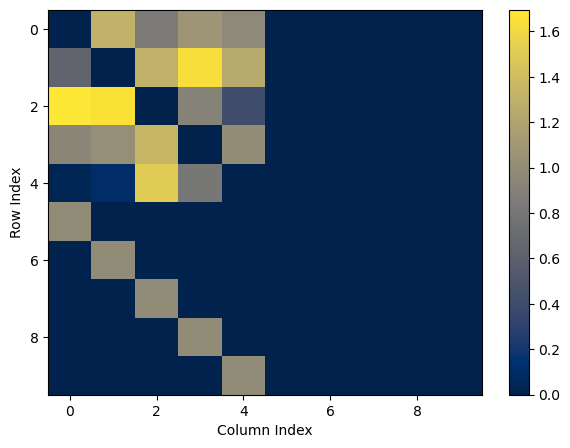

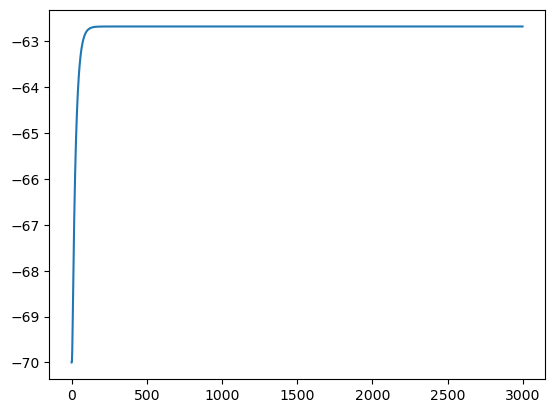

In [3]:
import pandas as pd
import numpy as np
from scripts import neuron_categorization, optimization, model, visualizations, preprocessing
import matplotlib.pyplot as plt

spike_trains = np.load('/hpc/mzhu843/modelling/nest/DATA/processed/spikes/S_3_p.npy')
calcium_traces = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')





model = model.Model2(small_categorized_neurons)

visualizations.plot_matrix(model.weights)
                                                                                                                            
model.simulate()


voltages_trace_pyr = model.voltage_traces_pyr



ts = range(len(voltages_trace_pyr[0]))
i=1
for trace in voltages_trace_pyr:
    plt.plot(ts, trace)
    plt.savefig('/hpc/mzhu843/modelling/nest/plots/temp results/Neuron ' + str(i))
    plt.close()
    i += 1




plt.plot(ts, voltages_trace_pyr[1])
plt.show()










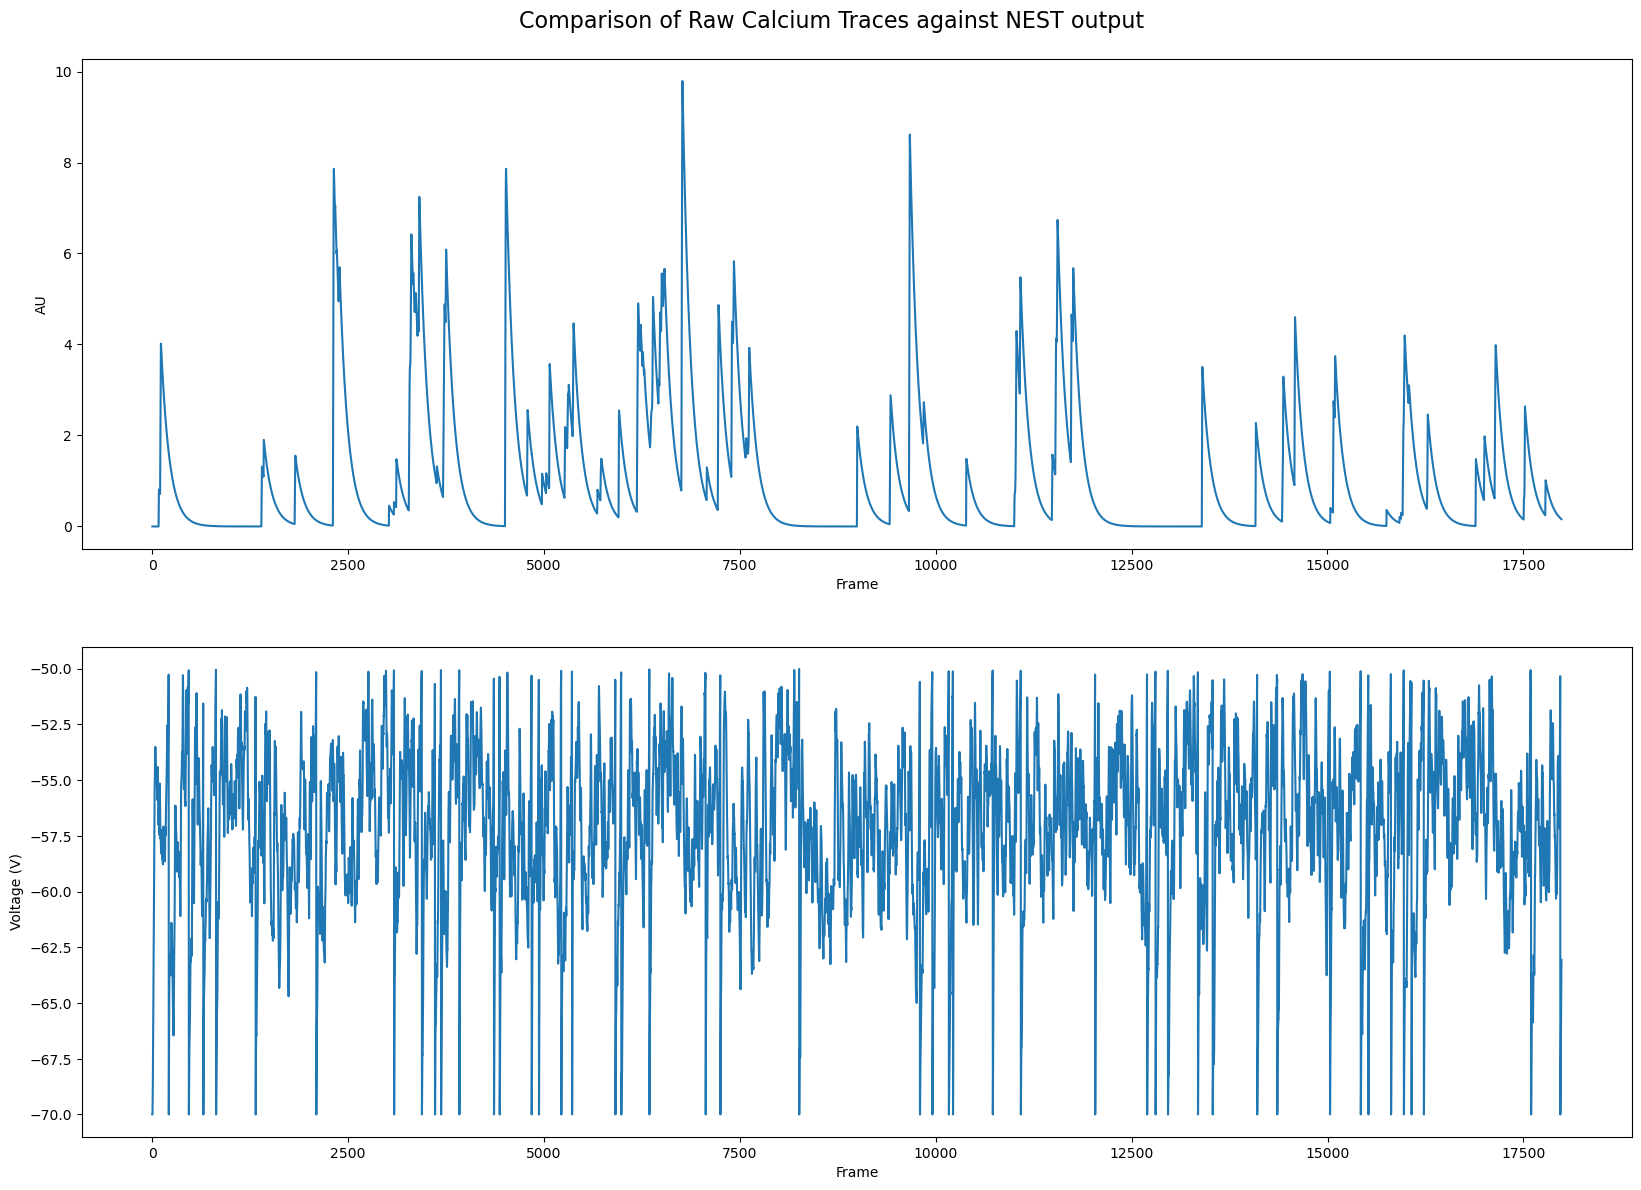

In [4]:
import numpy as np
import nest
import matplotlib.pyplot as plt

from params import pyr_hcamp_deco2012
from scripts import visualizations

calcium_trace_1 = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/calcium traces/C_3.npy')[83]

pyr = nest.Create('iaf_psc_alpha', n=1, params=pyr_hcamp_deco2012.params)
external_input = nest.Create('poisson_generator', n=10)
external_input.set(rate=40)

external_parrot = nest.Create('parrot_neuron', n=1)


nest.Connect(external_input, external_parrot)
nest.Connect(external_parrot, pyr, syn_spec={'weight': 90})

Vm_recorder = nest.Create('multimeter')
Vm_recorder.set(record_from=['V_m'])
nest.Connect(Vm_recorder, pyr)

spike_recorder = nest.Create('spike_recorder')
nest.Connect(pyr, spike_recorder)

nest.Simulate(17988)

ts = Vm_recorder.get('events')['times']
vms = Vm_recorder.get('events')['V_m']
fig, axs = plt.subplots(2, 1, figsize=(20, 14))
axs[0].plot(calcium_trace_1)
axs[0].set_ylabel('AU')
axs[0].set_xlabel('Frame')


axs[1].plot(vms)
axs[1].set_ylabel('Voltage (V)')
axs[1].set_xlabel('Frame')

fig.suptitle('Comparison of Raw Calcium Traces against NEST output', y=0.915, fontsize = 16)
plt.savefig('/hpc/mzhu843/modelling/nest/plots/raw_vs_simulation.png')





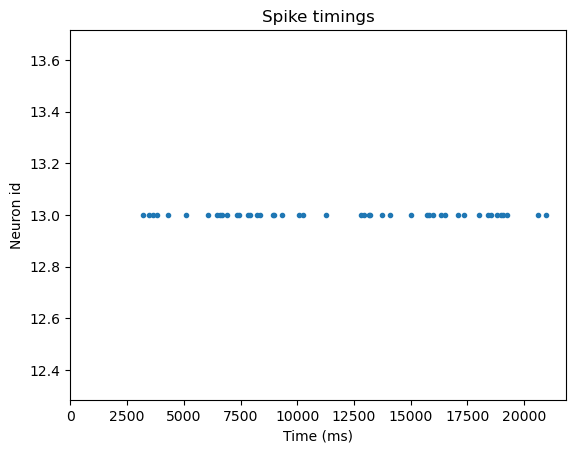

In [5]:
visualizations.plot_spikes_from_device(spike_recorder) 

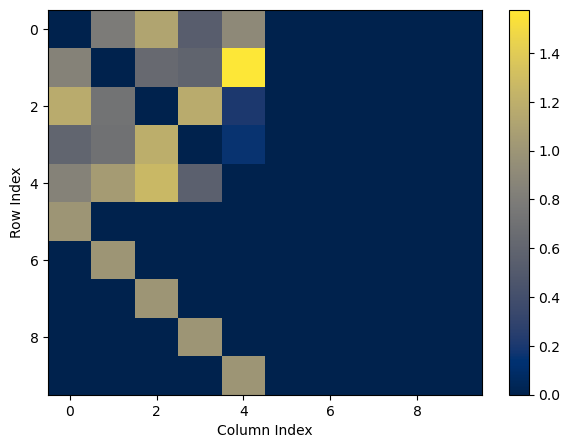

In [6]:
import numpy as np
from scripts import visualizations

matrix = np.load('/hpc/mzhu843/modelling/nest/DATA/raw/inital_matrices/model2/initial_weights.npy')
visualizations.plot_matrix(matrix)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 28 2023 11:53:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000      78000.54     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000      83417.71     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000      76583.86     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000      65132.53     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000      67178.14     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000      75337.13     0.00%     0.00%     0:00:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000      67476.81     0.00%     0.00%     0:00:01     0:00:00 Temperature 

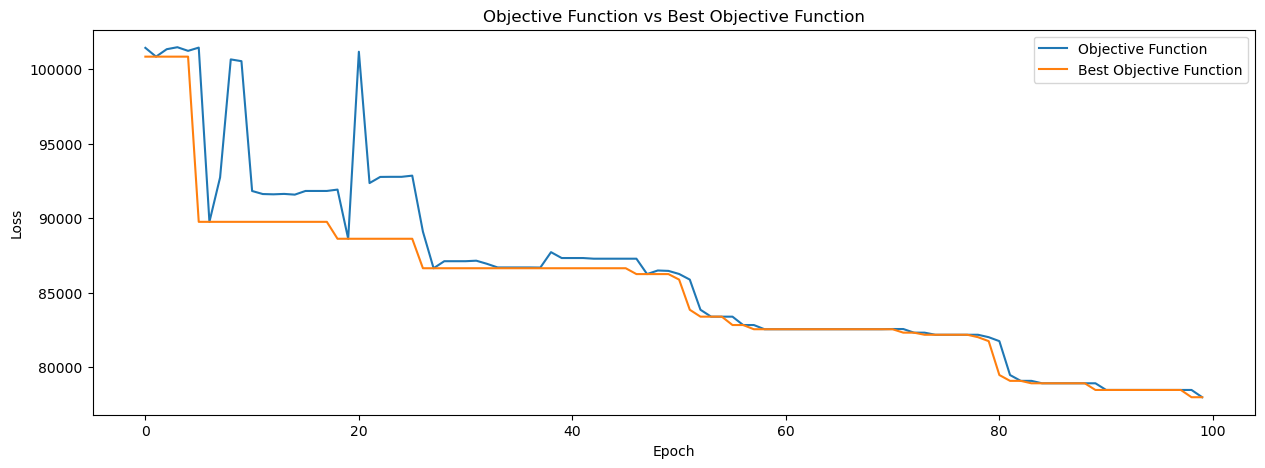

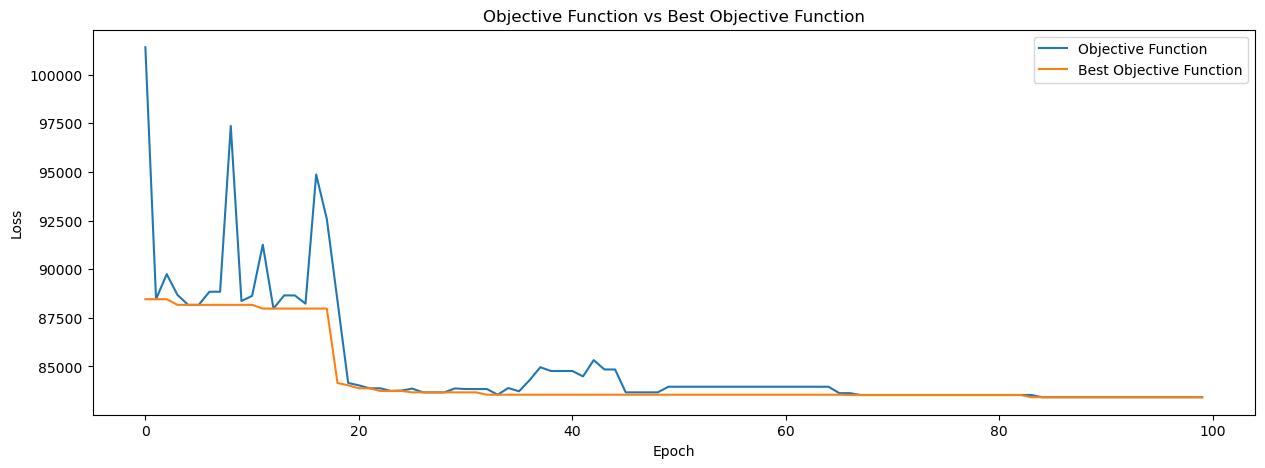

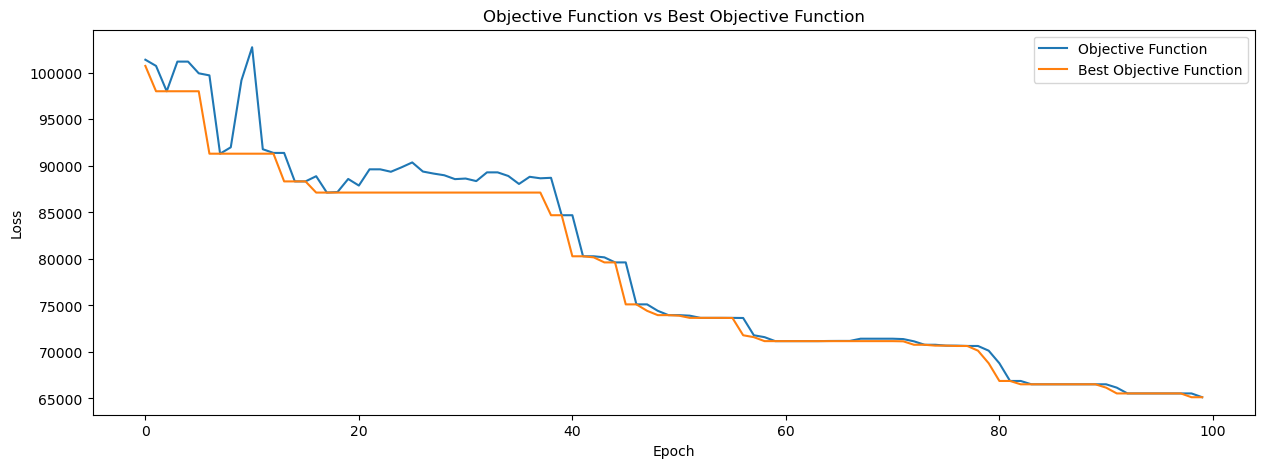

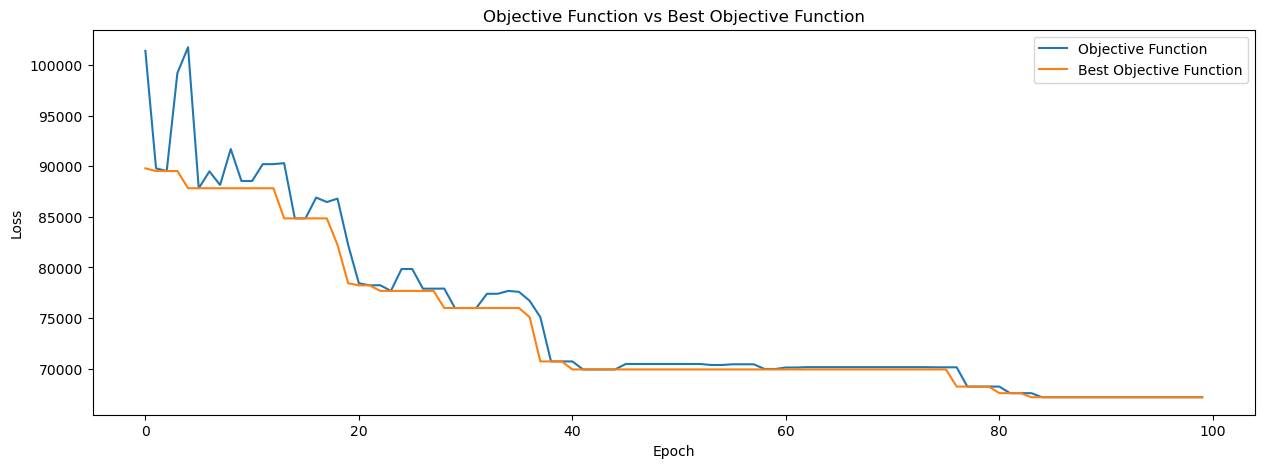

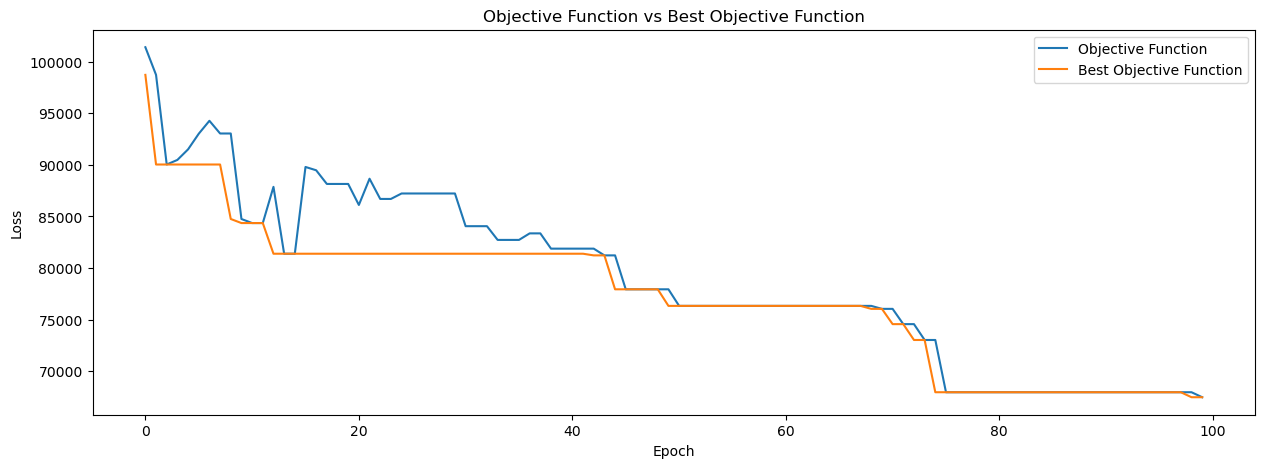

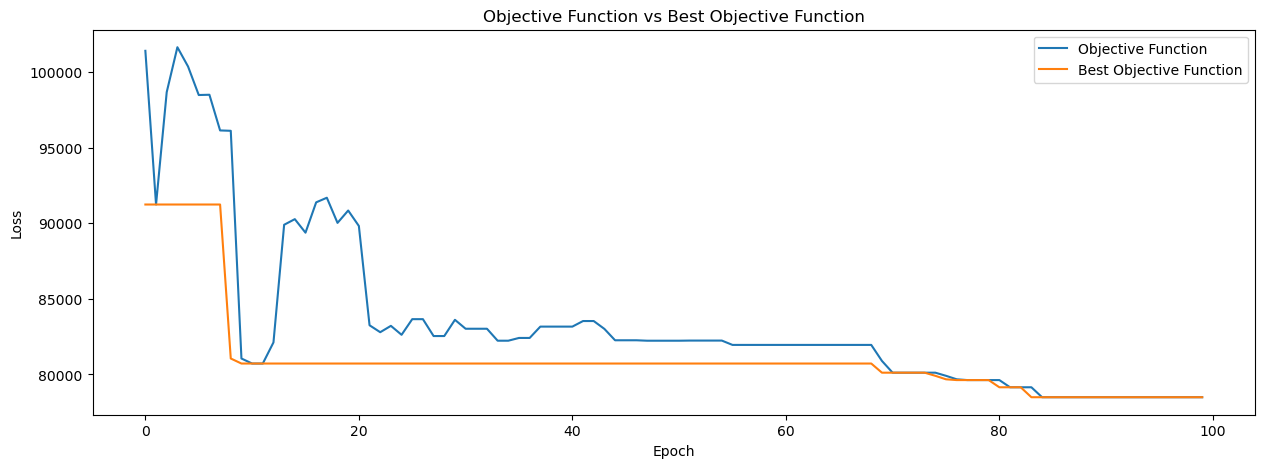

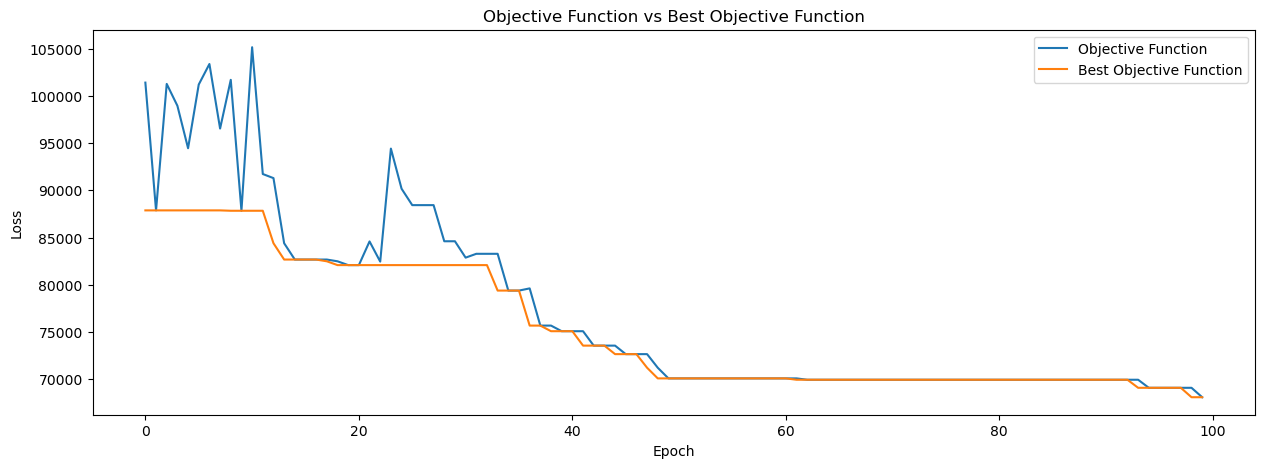

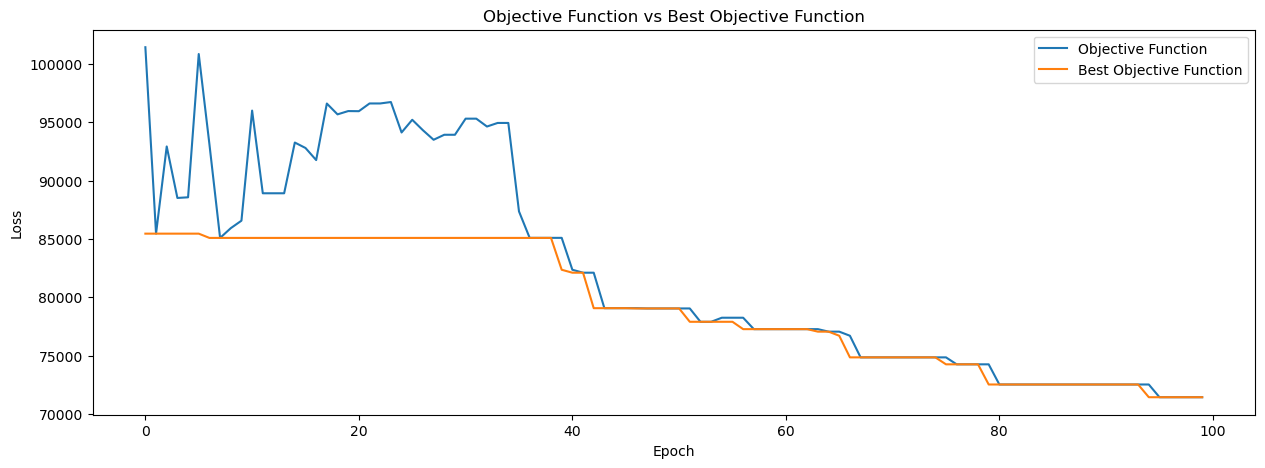

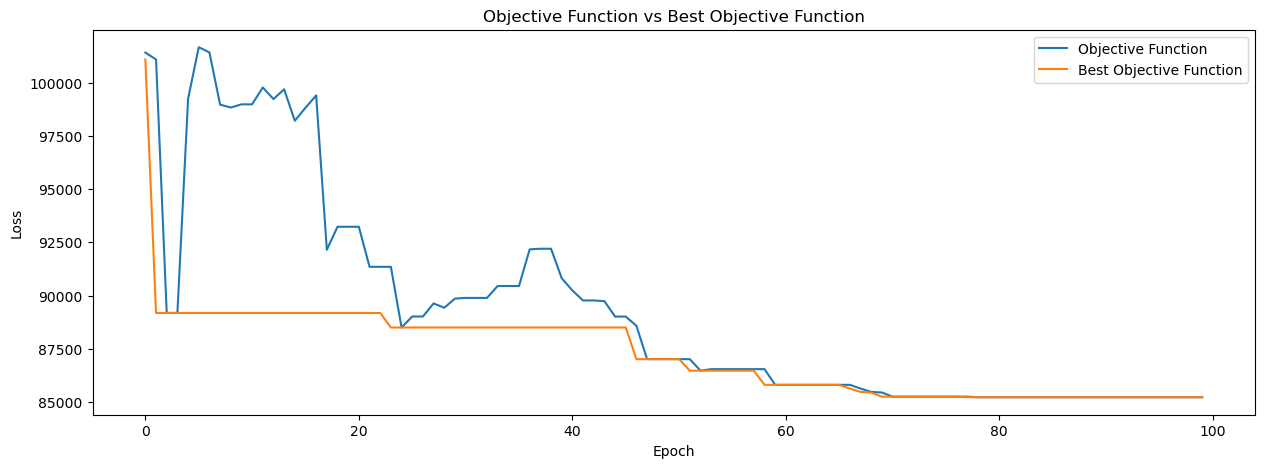

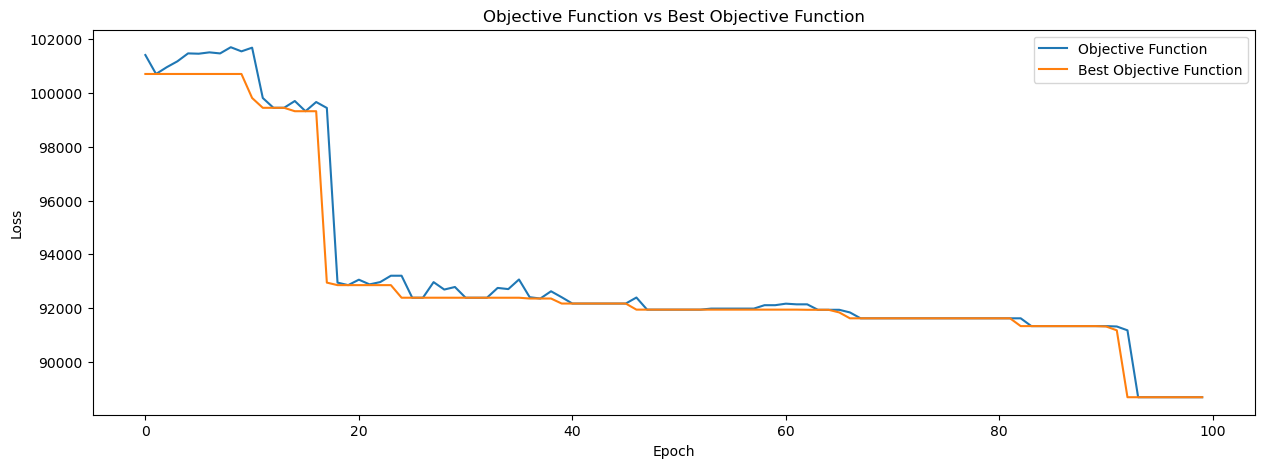

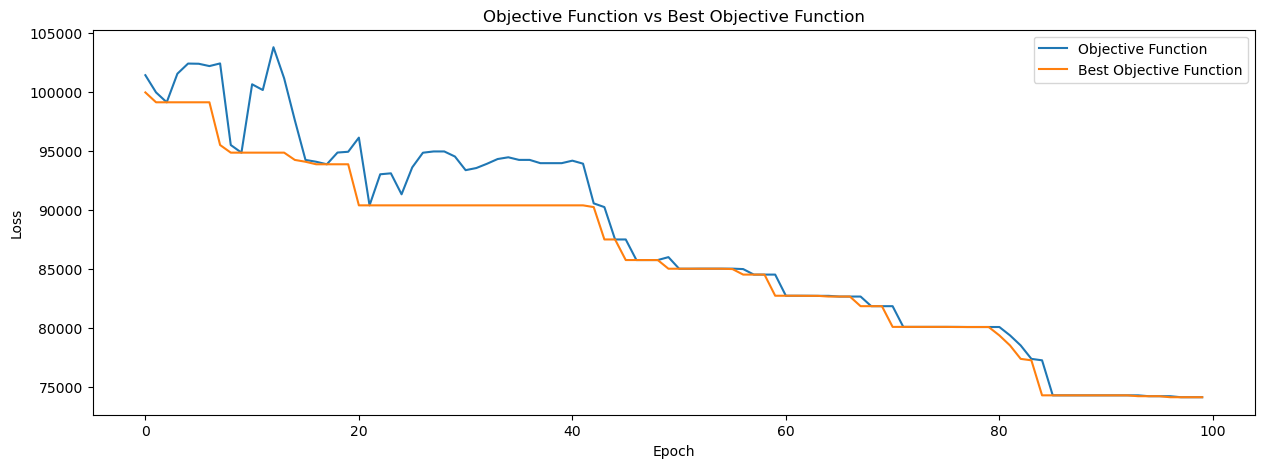

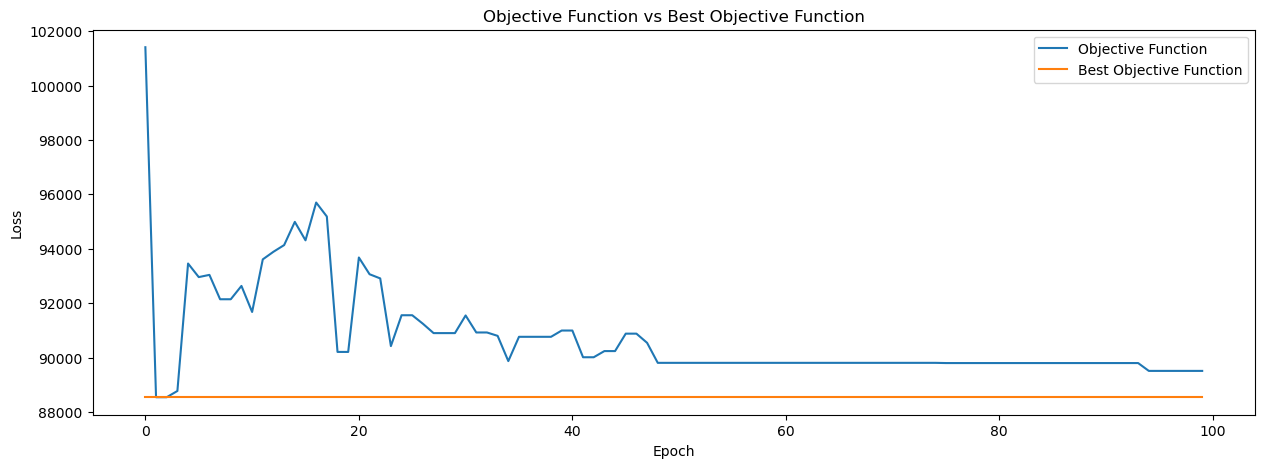

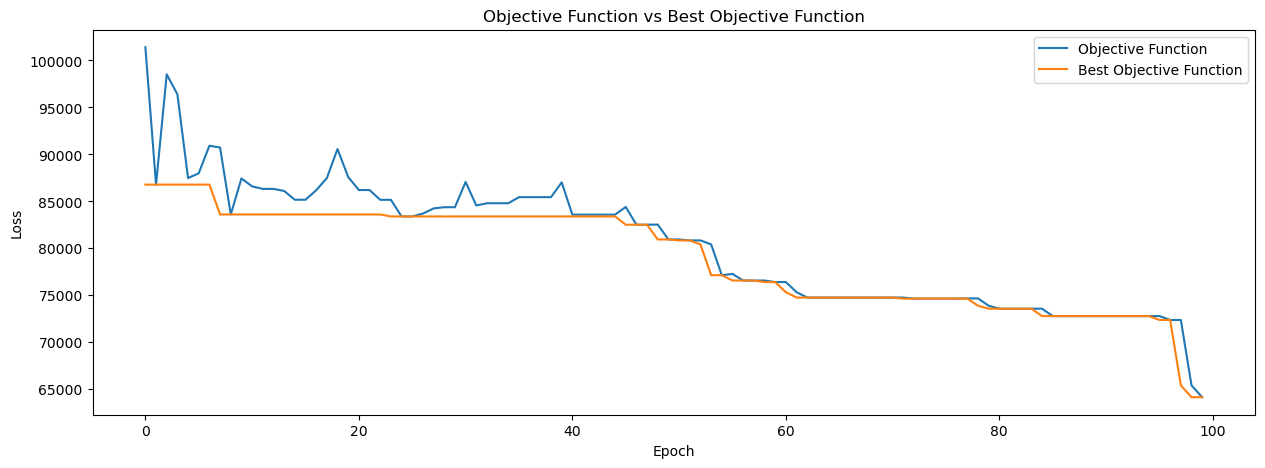

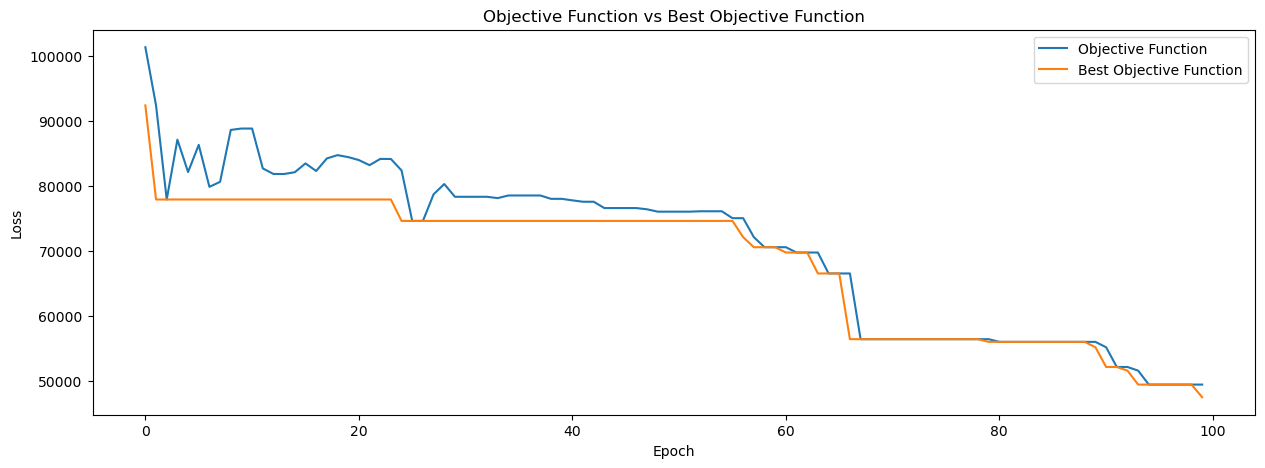

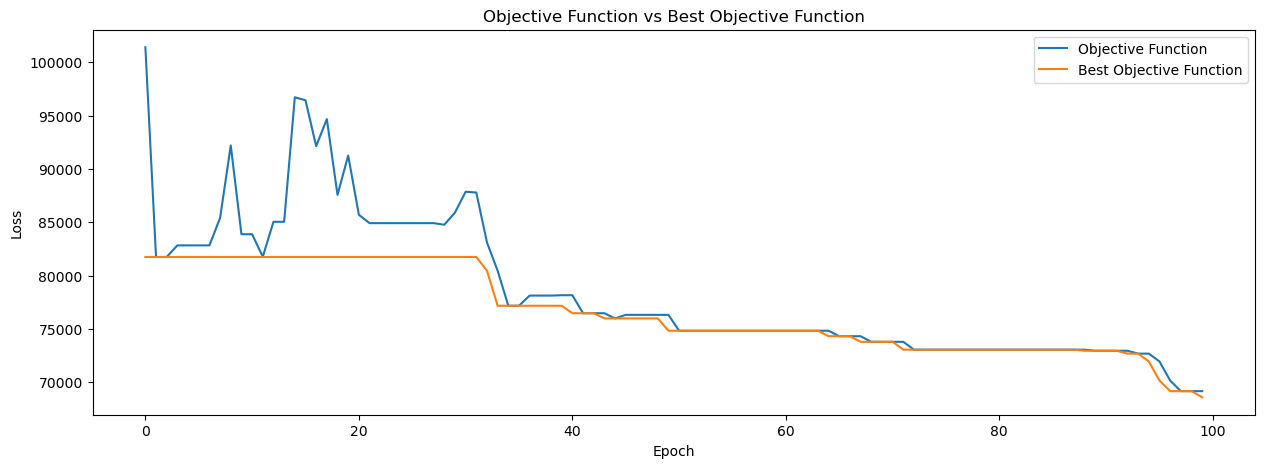

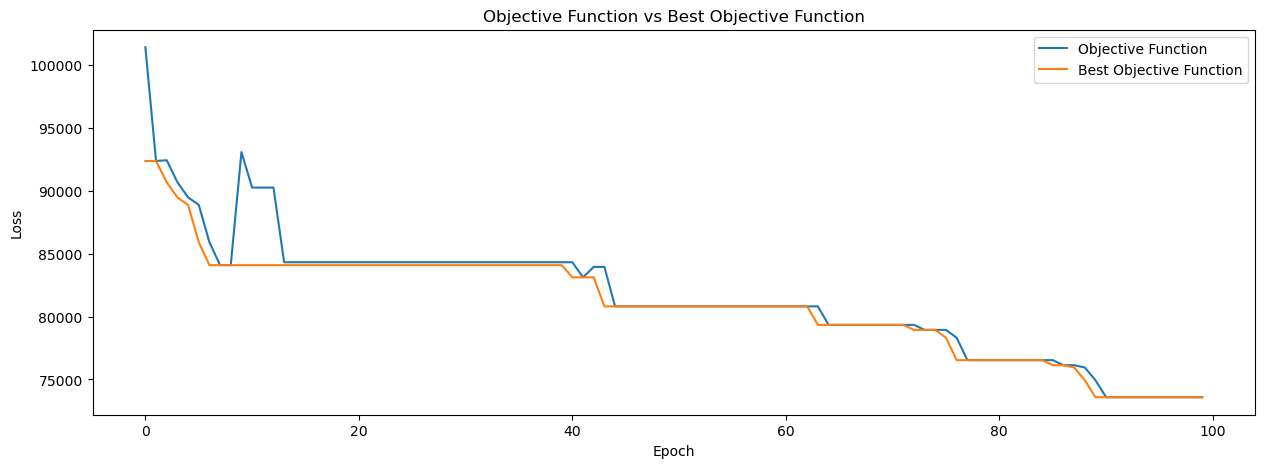

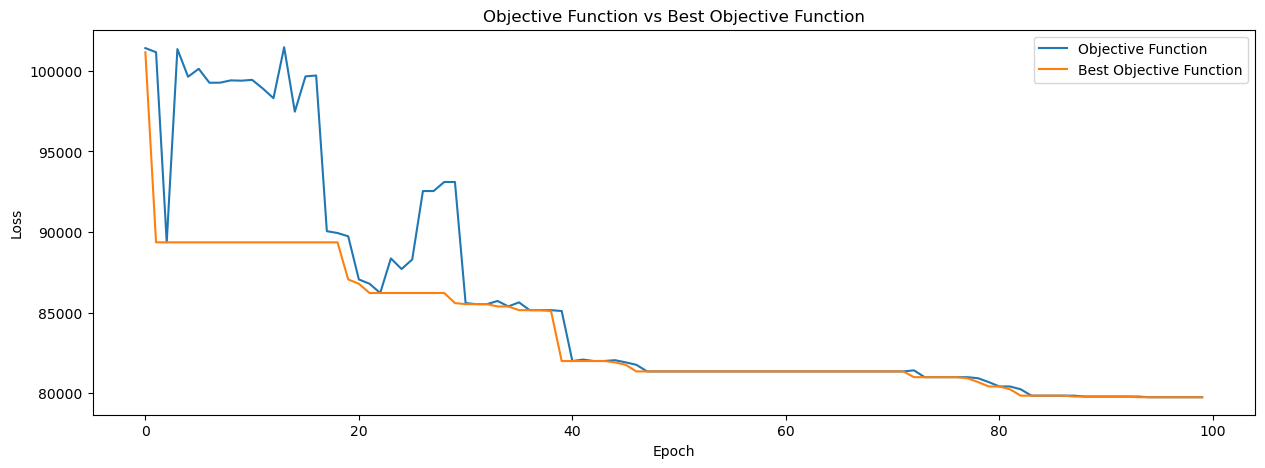

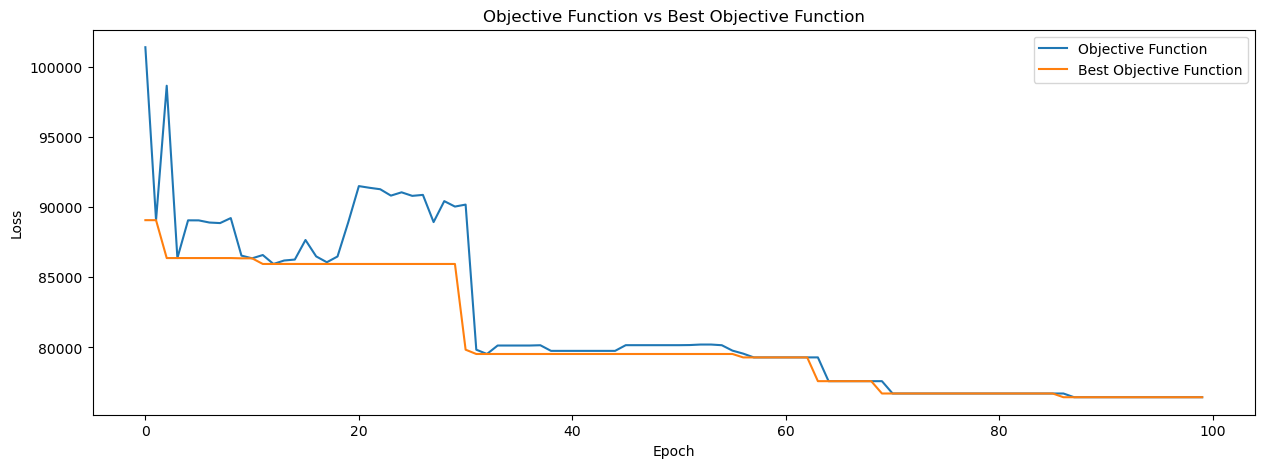

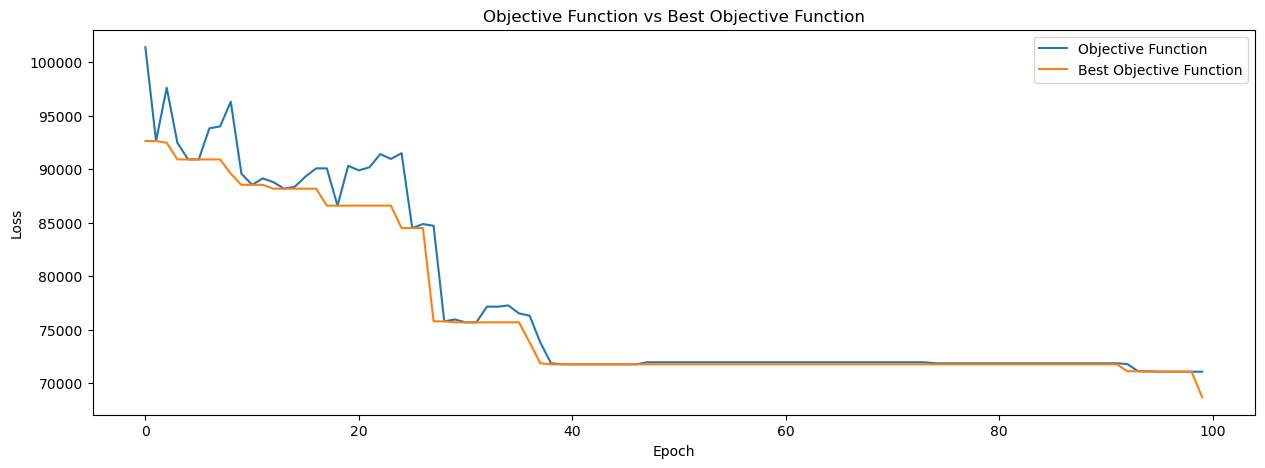

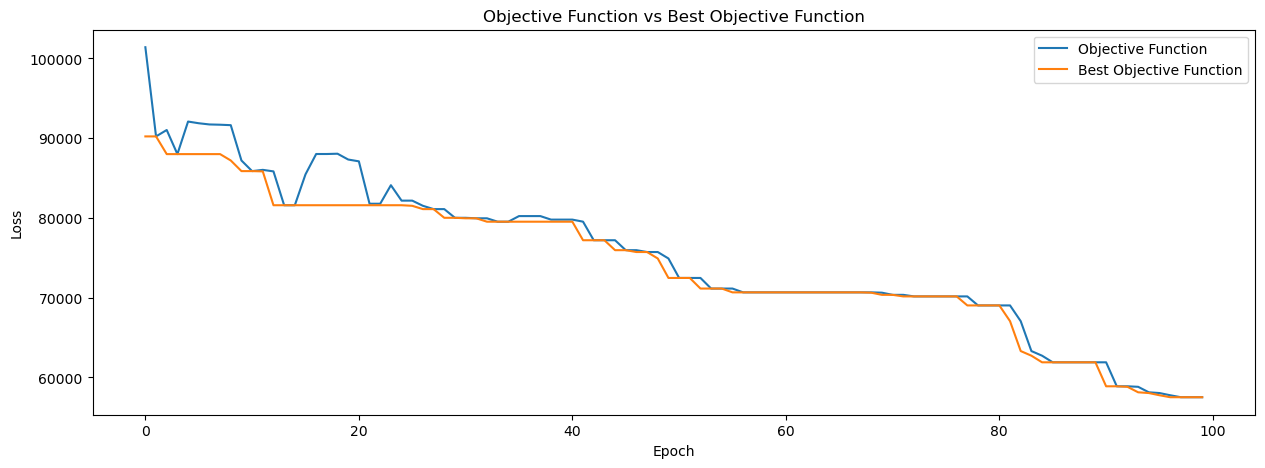

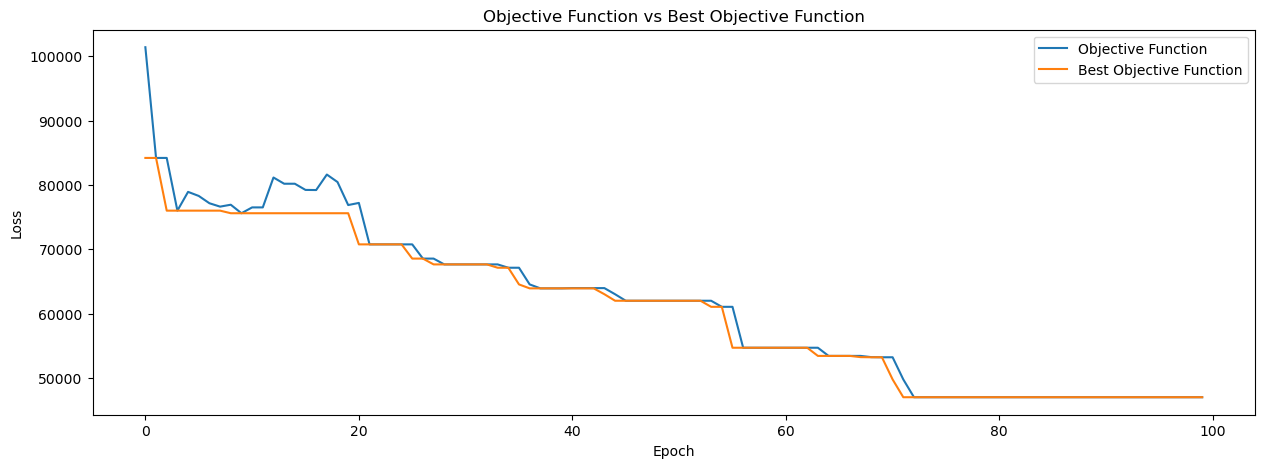

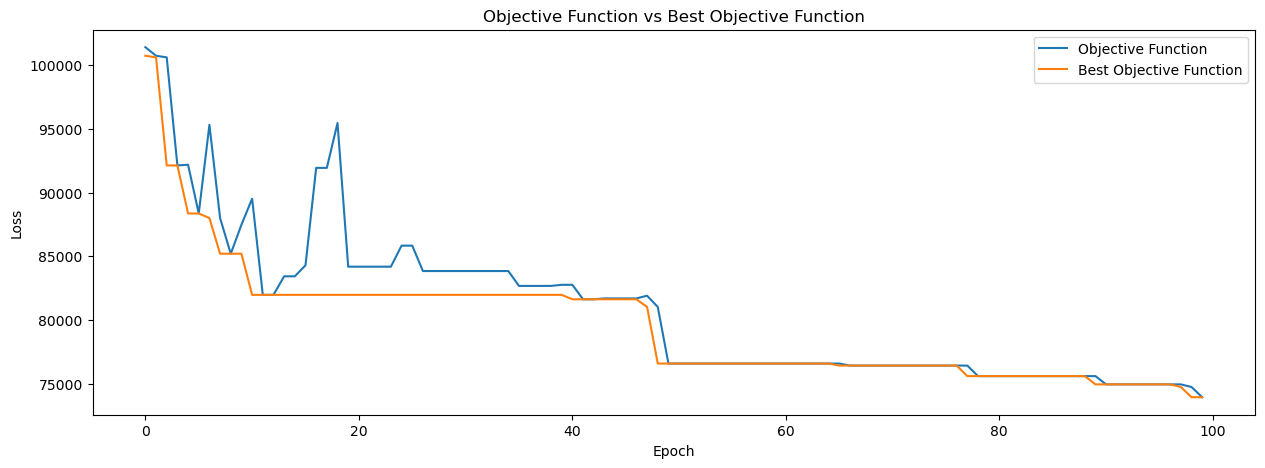

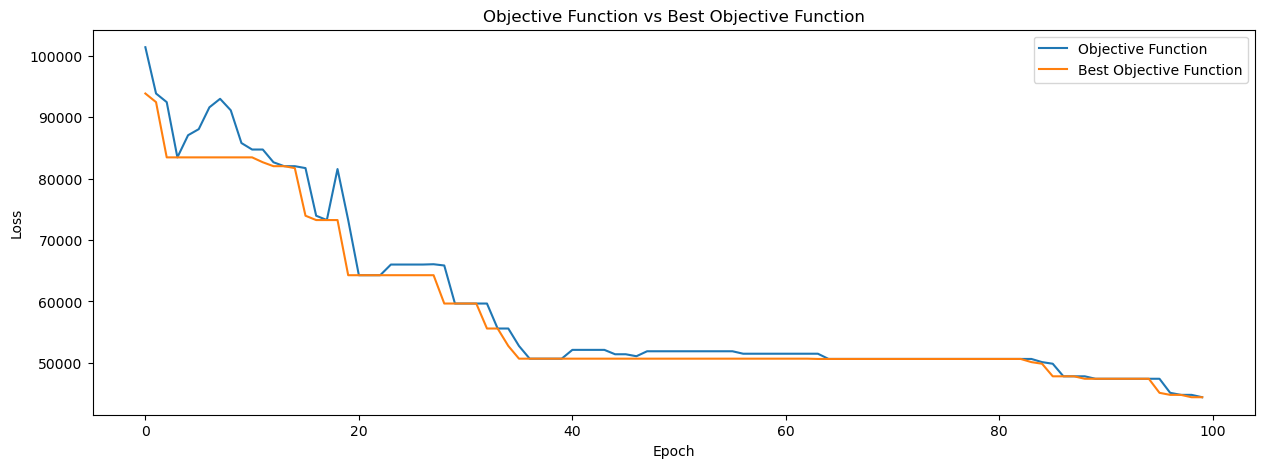

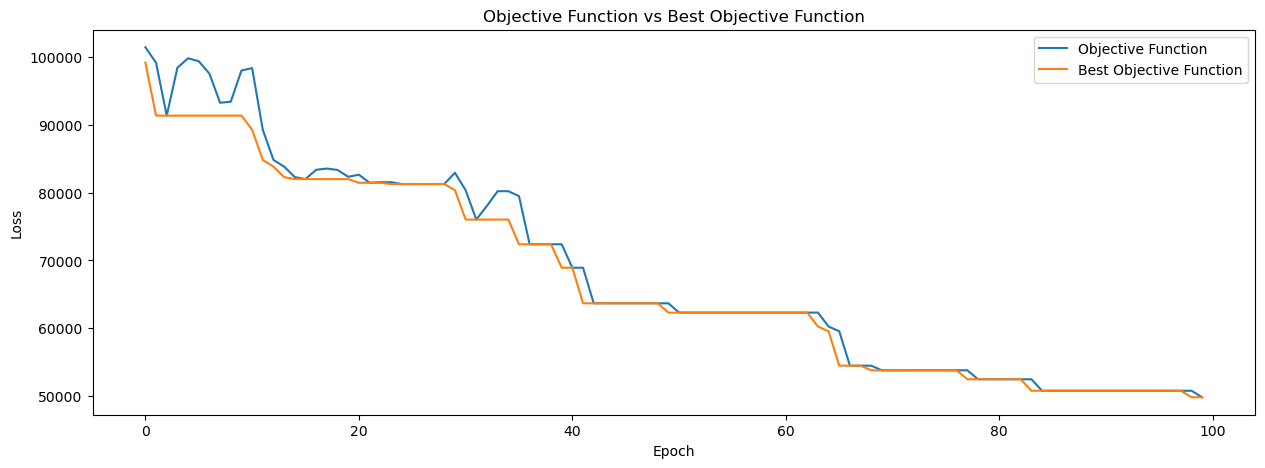

In [1]:
from scripts import optimization, model
import numpy as np
import pickle

first_weights = np.zeros((10, 10))

for i in range(5):
    first_weights[i][0:5] = np.random.normal(1, scale=0.4, size=5)
    first_weights[i + 5][i] = 1

for i in range(10):
    first_weights[i][i] = 0


first_spike_weights = np.random.normal(2.5, scale=3, size=(5, 3000))

with open('/hpc/mzhu843/modelling/nest/DATA/processed/model2/categorized_neurons.pkl', 'rb') as file:
    # Load the object from the file
    small_categorized_neurons = pickle.load(file)

network = model.Model2(small_categorized_neurons, first_spike_weights, first_weights)

network.simulate()

place_obs = network.get_voltage_traces()

from scripts import optimization
import numpy as np

second_weights = np.zeros((10, 10))

for i in range(5):
    second_weights[i][0:5] = np.random.randint(-3, 3, size=5)
    second_weights[i + 5][i] = 1

for i in range(10):
    second_weights[i][i] = 0

second_spike_weights = np.random.normal(2.5, scale=3, size=(5, 3000))

move_params = {
                'weights_range': [(-5, 5), (-4, 4), (-3, 3)],
                'weights_change_range': [(-0.1, 0.1), (-0.2, 0.2), (-0.3, 0.3), (-0.4, 0.4)],
                'spike_weights_range': [(-5, 5)],
                'spike_weights_change_range': [(-2, 2)],
                'spike_weights_prob' : [0.2],
                'optimise_spike_weights': [False]
            }

lamb = 0.01

problem = optimization.SimulatedAnnealing2(second_weights, place_obs , lamb, small_categorized_neurons, first_spike_weights, move_params)
problem.steps = 100

sensitivity_analysis = optimization.SensitivityAnalysis(move_params, problem, save_results=True)
param_perms = sensitivity_analysis.generate_param_permutations()
sensitivity_analysis.run_analysis()
